In [2]:
# A décommenter à la première exécution si jupyter se plaint de ne pas trouver oracledb
!pip install --upgrade oracledb

  Using cached oracledb-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.1 MB)


In [3]:
# Compléter ici les imports dont vous avez besoin, ne pas modifier ceux déjà présents
import getpass
from os import getenv
import pandas as pd
import oracledb
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Nécessaire pour éviter les problèmes de session
class Connexion(object):
    def __init__(self, login, password):
        self.conn = oracledb.connect(
            user=login,
            password=password,
            host="oracle.iut-orsay.fr",
            port=1521,
            sid="etudom",
        )
        self.conn.autocommit = False

    def __enter__(self):
        self.conn.autocommit = False
        return self.conn

    def __exit__(self, *args):
        self.conn.close()

In [5]:
# La fonction ci-dessous est à utiliser pour exécuter une requête et stocker les résultats dans un dataframe Pandas sans afficher d’alerte.
# Vous pouvez vous en inspirer pour créer vos propres fonctions.
def requete_vers_dataframe(connexion_data, requete, valeurs = None):
    with Connexion(login=connexion_data['login'], password=connexion_data['password']) as connexion:
        warnings.simplefilter(action='ignore', category=UserWarning)
        if valeurs is not None:
            df = pd.read_sql(requete, connexion, params=valeurs)
        else:
            df = pd.read_sql(requete, connexion)
        warnings.simplefilter("always") 
        return df

In [6]:
# Saisir ci-dessous l'édition des JO qui vous a été attribuée. Cela correspond au LibelleHote dans la table HOTE de la base de données
# Par exemple EDITION_JO = "2020 Summer Olympics"
EDITION_JO = "1976 Summer Olympics"
# Saisir ci-dessous le login court de la base utilisée pour votre carnet
SCHEMA = "TPLUMAS"

# TABLEAU DE BORD DES JO

## Partie consultation des données

In [7]:
# On demande à l'utilisateur son login et mot de passe pour pouvoir accéder à la base de données
if getenv("DB_LOGIN") is None:
    login = input("Login : ")
else:
    login = getenv("DB_LOGIN")
if getenv("DB_PASS") is None:
    password = getpass.getpass("Mot de passe : ")
else:
    password = getenv("DB_PASS")
conn = {'login': login, 'password': password}

In [8]:
# On vérifie que l'utilisateur est bien connecté à la base de données, que le schéma est bon, et qu'on trouve la bonne édition des JO
data = requete_vers_dataframe(conn, f"SELECT * FROM {SCHEMA}.HOTE WHERE LibelleHote LIKE (:libelle)",{"libelle":EDITION_JO})
id_hote = int(data.IDHOTE.iloc[0])
print(f"Identifiant de l’hôte : {id_hote}")

Identifiant de l’hôte : 19


### Statistiques de base : participation

#### Nombre de nations participant à ces JO

In [8]:
data = requete_vers_dataframe(conn,f"""
SELECT COUNT(DISTINCT noc) AS NombreNations
FROM (
    SELECT pi.noc
    FROM {SCHEMA}.participation_individuelle pi
    JOIN {SCHEMA}.evenement e ON pi.idEvent = e.idEvenement
    WHERE e.idHote = (
        SELECT idHote
        FROM {SCHEMA}.hote
        WHERE LibelleHote LIKE (:Libelle)
    )
    UNION
    SELECT e.noc
    FROM {SCHEMA}.participation_equipe pe
    JOIN {SCHEMA}.evenement ev ON pe.idEvenement = ev.idEvenement
    JOIN {SCHEMA}.equipe e ON pe.idEquipe = e.idEquipe
    WHERE ev.idHote = (
        SELECT idHote
        FROM {SCHEMA}.hote
        WHERE LibelleHote LIKE (:Libelle)
    )
)
"""
,{"libelle":EDITION_JO})
nombre_nations = int(data["NOMBRENATIONS"].iloc[0])
print(f"Nombre de nations participant aux {EDITION_JO} : {nombre_nations}")

Nombre de nations participant aux 1976 Summer Olympics : 92


#### Nombre d'athlètes participant à ces JO, répartition par genre et /ou par pays

In [9]:
data = requete_vers_dataframe(conn, f"""
SELECT
    a.genre as genre,
    pi.noc as noc,
    COUNT(DISTINCT a.idAthlete) AS NombreAthletes
FROM
    {SCHEMA}.ATHLETE a
JOIN
    {SCHEMA}.PARTICIPATION_INDIVIDUELLE pi ON a.idAthlete = pi.idAthlete
JOIN
    {SCHEMA}.EVENEMENT e ON pi.idEvent = e.idEvenement
JOIN
    {SCHEMA}.HOTE h ON e.idHote = h.idHote
WHERE
    h.LibelleHote LIKE :Libelle
GROUP BY
    a.genre, pi.noc

UNION ALL

SELECT
    a.genre as genre,
    eq.noc as noc,
    COUNT(DISTINCT a.idAthlete) AS NombreAthletes
FROM
    {SCHEMA}.ATHLETE a
JOIN
    {SCHEMA}.COMPOSITION_EQUIPE ce ON a.idAthlete = ce.idAthlete
JOIN
    {SCHEMA}.EQUIPE eq ON ce.idEquipe = eq.idEquipe
JOIN
    {SCHEMA}.PARTICIPATION_EQUIPE pe ON eq.idEquipe = pe.idEquipe
JOIN
    {SCHEMA}.EVENEMENT ev ON pe.idEvenement = ev.idEvenement
JOIN
    {SCHEMA}.HOTE ht ON ev.idHote = ht.idHote
WHERE
    ht.LibelleHote LIKE :Libelle
GROUP BY
    a.genre, eq.noc
ORDER BY
    noc
"""
, {"libelle": EDITION_JO})
nombre_athletes = int(data["NOMBREATHLETES"].iloc[0])
print(data)

      GENRE  NOC  NOMBREATHLETES
0      Male  AHO               4
1      Male  AND               3
2      Male  ANT               7
3      Male  ANT               7
4      Male  ARG              37
..      ...  ...             ...
248    Male  VEN              21
249  Female  VEN               9
250  Female  YUG               5
251    Male  YUG              39
252    Male  YUG              44

[253 rows x 3 columns]


### Les médailles décernées lors de ces JO

#### Médailles individuelles (épreuves individuelles)

##### Tableau du TOP 10 individuel

In [10]:
data = requete_vers_dataframe(conn, f"""
SELECT
    a.nomAthlete,
    a.prenomAthlete,
    a.genre,
    pi.noc,
    pi.medaille,
    e.nomEvenement
FROM
    {SCHEMA}.ATHLETE a
JOIN
    {SCHEMA}.PARTICIPATION_INDIVIDUELLE pi ON a.idAthlete = pi.idAthlete
JOIN
    {SCHEMA}.EVENEMENT e ON pi.idEvent = e.idEvenement
JOIN
    {SCHEMA}.HOTE h ON e.idHote = h.idHote
WHERE
    h.LibelleHote LIKE :Libelle
""", {"Libelle": EDITION_JO})

# Display the column names to verify them
print(data.columns)

# Display the first few rows of the DataFrame
data.head()

Index(['NOMATHLETE', 'PRENOMATHLETE', 'GENRE', 'NOC', 'MEDAILLE',
       'NOMEVENEMENT'],
      dtype='object')


,NOMATHLETE,PRENOMATHLETE,GENRE,NOC,MEDAILLE,NOMEVENEMENT
0,Bruner,Mike,Male,USA,Gold,"200 metres Butterfly, Men"
1,Dolzhenko-Krachevskaya,Esfir,Female,URS,None,"Shot Put, Women"
2,Senyukov,Sergey,Male,URS,None,"High Jump, Men"
3,Fredriksson,Anette,Female,SWE,None,"100 metres Breaststroke, Women"
4,Fredriksson,Anette,Female,SWE,None,"200 metres Breaststroke, Women"


           Nom    Prenom  NOC  NombreMedaille
0    Andrianov   Nikolay  URS               6
1     Comăneci     Nadia  ROU               4
2    Tsukahara    Mitsuo  JPN               4
3    Babashoff   Shirley  USA               3
4        Ender  Kornelia  GDR               3
5          Kim     Nelli  URS               3
6        Naber      John  USA               3
7  Turishcheva  Lyudmila  URS               3
8     Brigitha     Enith  NED               2
9         Dîba    Vasile  ROU               2


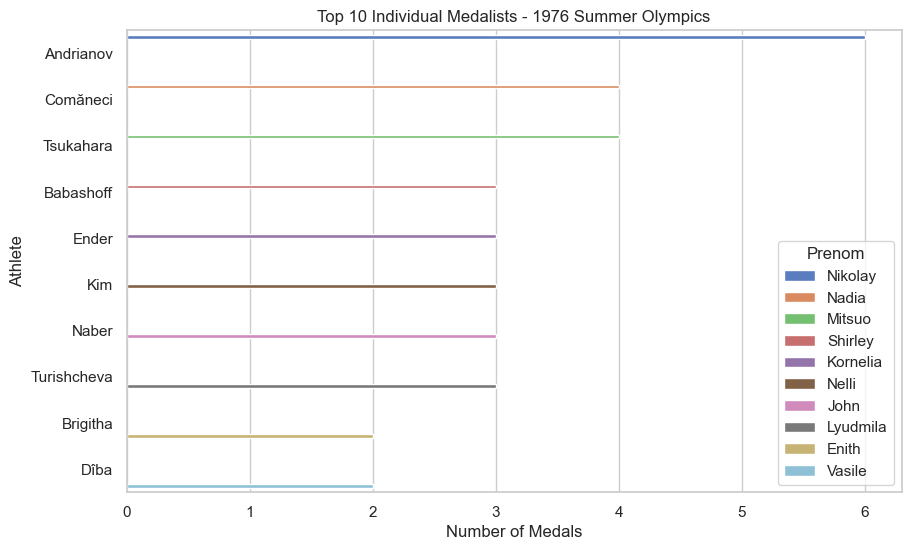

In [11]:
# Assuming the column names are correct, aggregate the data to get the top 10 athletes based on the number of medals
top_10_individuals = data.groupby(['NOMATHLETE', 'PRENOMATHLETE', 'NOC'])['MEDAILLE'].count().nlargest(10).reset_index()
top_10_individuals.columns = ['Nom', 'Prenom', 'NOC', 'NombreMedaille']
print(top_10_individuals)

# Set the plot style
sns.set(style="whitegrid")

# Create a bar plot for the top 10 individual medalists
plt.figure(figsize=(10, 6))
sns.barplot(
    x='NombreMedaille', 
    y='Nom', 
    hue='Prenom',
    data=top_10_individuals.sort_values(by='NombreMedaille', ascending=False),
    palette='muted'
)

# Add title and labels
plt.title('Top 10 Individual Medalists - 1976 Summer Olympics')
plt.xlabel('Number of Medals')
plt.ylabel('Athlete')

# Show the plot
plt.show()

##### Répartition par NOC

In [35]:
# Requête SQL pour récupérer les informations des médailles par pays (NOC)
data = requete_vers_dataframe(conn, f"""
SELECT
    pi.noc,
    pi.medaille
FROM
    {SCHEMA}.PARTICIPATION_INDIVIDUELLE pi
JOIN
    {SCHEMA}.EVENEMENT e ON pi.idEvent = e.idEvenement
JOIN
    {SCHEMA}.HOTE h ON e.idHote = h.idHote
WHERE
    h.LibelleHote LIKE :Libelle
""", {"Libelle": EDITION_JO})

# Afficher les premières lignes du DataFrame pour vérifier les données
data.head()

,NOC,MEDAILLE
0,AND,None
1,AND,None
2,AND,None
3,ANT,None
4,ANT,None


    NOC  NombreMedaille
0   AHO               0
1   AND               0
2   ANT               0
3   ARG               0
4   AUS               2
..  ...             ...
86  URS              93
87  URU               0
88  USA              78
89  VEN               1
90  YUG               7

[91 rows x 2 columns]


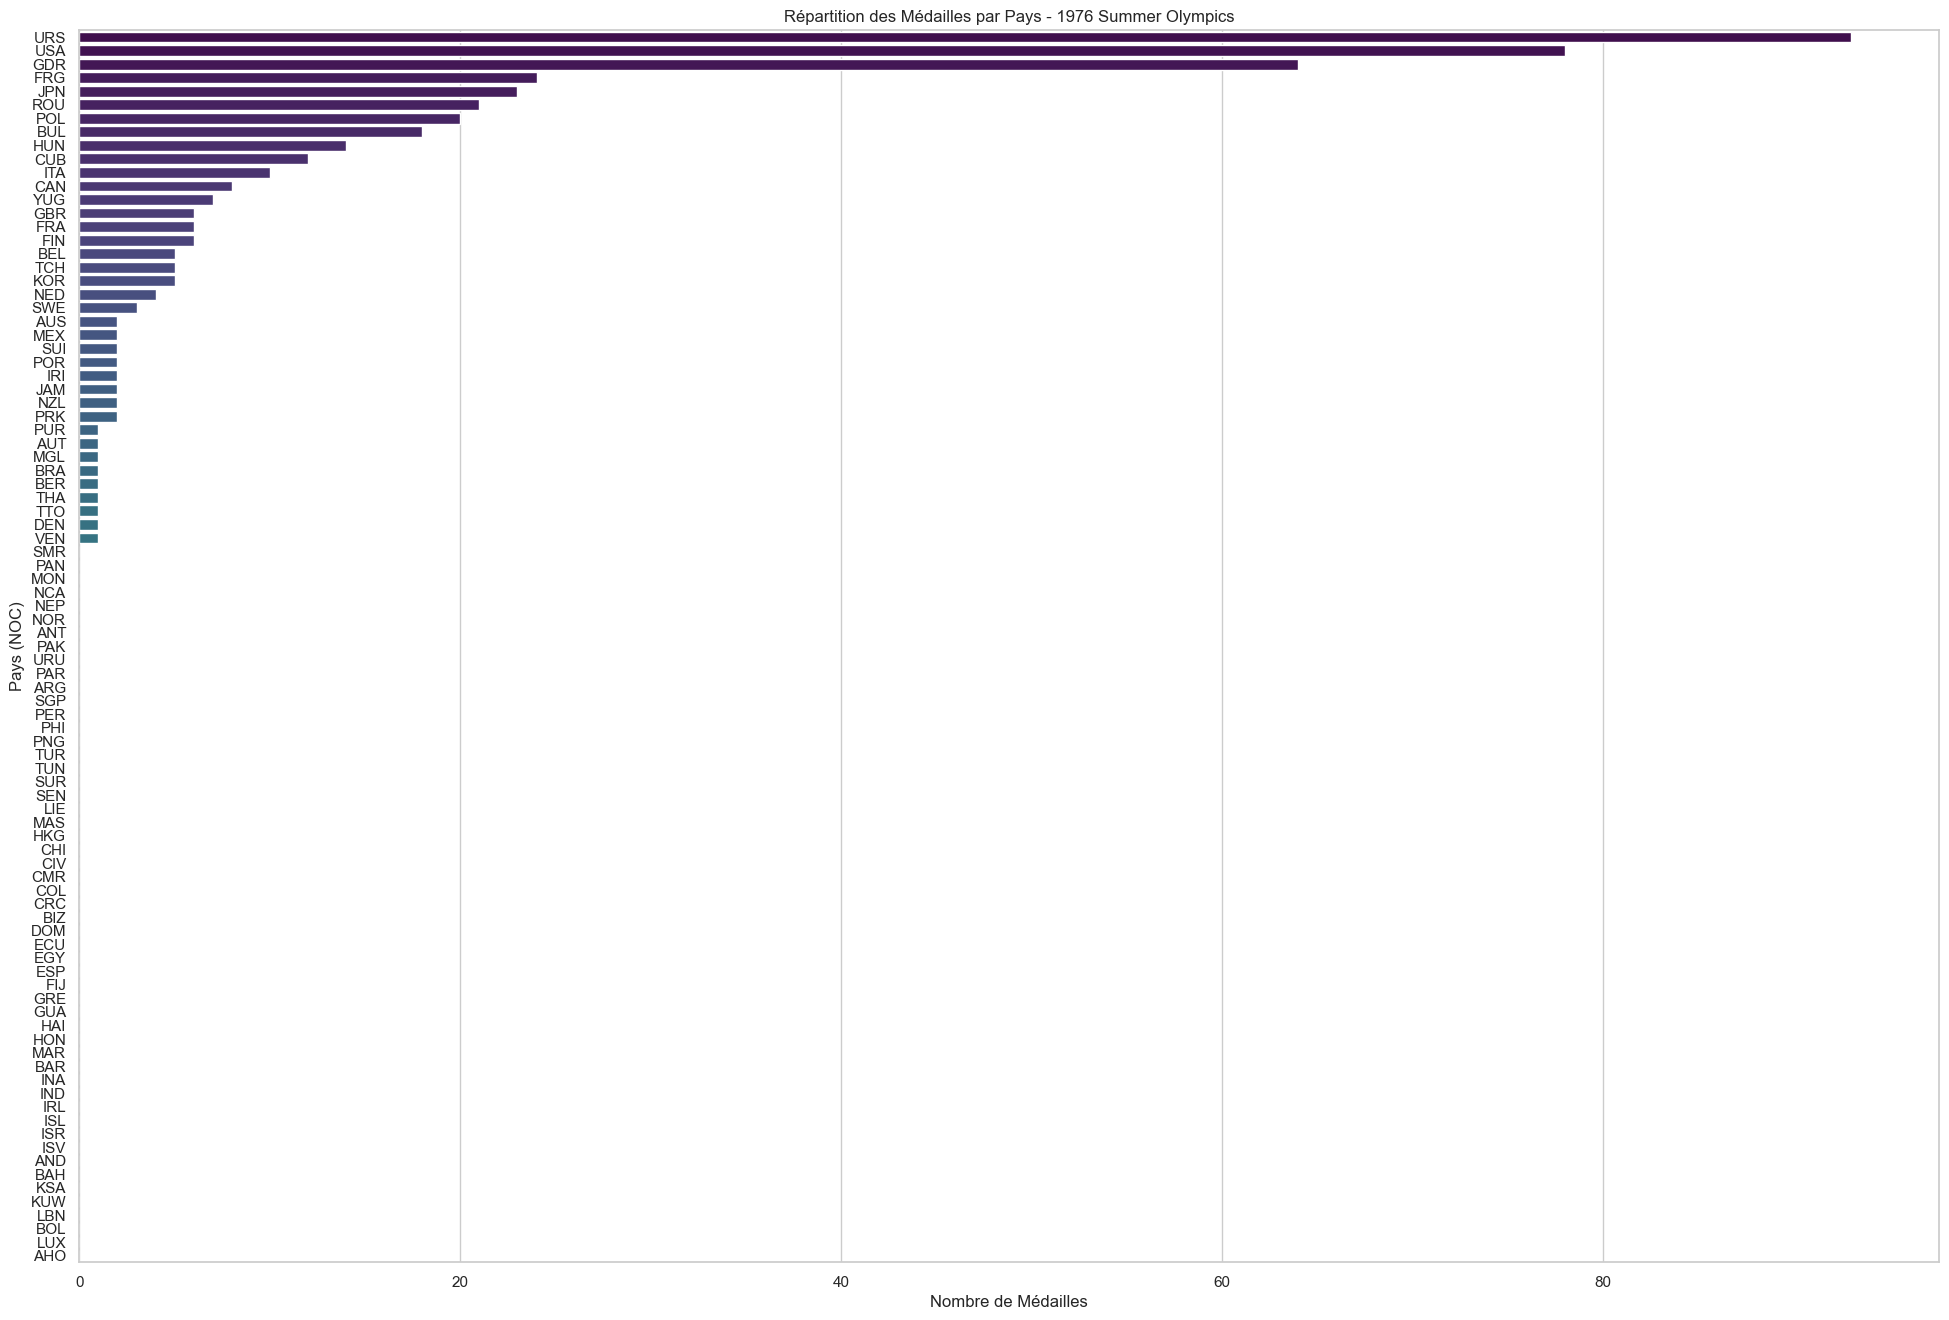

In [36]:
# Grouper les données par NOC et compter le nombre de médailles
medals_by_noc = data.groupby('NOC')['MEDAILLE'].count().reset_index()
medals_by_noc.columns = ['NOC', 'NombreMedaille']

# Afficher le tableau des médailles par pays
print(medals_by_noc)

# Configurer le style de Seaborn
sns.set(style="whitegrid")

# Créer un bar plot pour visualiser la répartition des médailles par pays
plt.figure(figsize=(24, 16))
sns.barplot(
    x='NombreMedaille', 
    y='NOC', 
    data=medals_by_noc.sort_values(by='NombreMedaille', ascending=False),
    palette='viridis'
)

# Ajouter un titre et des labels
plt.title('Répartition des Médailles par Pays - 1976 Summer Olympics')
plt.xlabel('Nombre de Médailles')
plt.ylabel('Pays (NOC)')

# Afficher le graphique
plt.show()

#### Médailles par équipes (épreuves par équipe)

##### Tableau du TOP 10 par équipe

In [14]:
# Requête SQL pour récupérer les informations des médailles par équipes et athlètes individuels avec la vue MEDAILLES_EQUIPE
data = requete_vers_dataframe(conn, f"""
SELECT
    a.nomAthlete,
    a.prenomAthlete,
    eq.noc,
    me.nbOrEquipe,
    me.nbArgentEquipe,
    me.nbBronzeEquipe
FROM
    {SCHEMA}.ATHLETE a
JOIN
    {SCHEMA}.COMPOSITION_EQUIPE ce ON a.idAthlete = ce.idAthlete
JOIN
    {SCHEMA}.EQUIPE eq ON ce.idEquipe = eq.idEquipe
JOIN
    {SCHEMA}.MEDAILLES_EQUIPE me ON ce.idAthlete = me.idAthlete
JOIN
    {SCHEMA}.PARTICIPATION_EQUIPE pe ON eq.idEquipe = pe.idEquipe    
JOIN
    {SCHEMA}.EVENEMENT e ON e.idEvenement = pe.idEvenement
JOIN
    {SCHEMA}.HOTE h ON e.idHote = h.idHote
WHERE
    h.LibelleHote LIKE :Libelle
ORDER BY
    me.nbOrEquipe DESC, me.nbArgentEquipe DESC, me.nbBronzeEquipe DESC
""", {"Libelle": EDITION_JO})

# Display the column names to verify them
data.columns

# Afficher les premières lignes du DataFrame pour vérifier les données
data.head()

,NOMATHLETE,PRENOMATHLETE,NOC,NBOREQUIPE,NBARGENTEQUIPE,NBBRONZEEQUIPE
0,Klimke,Reiner,FRG,5,0,0
1,Winkler,Hans Günter,FRG,4,1,1
2,Babashoff,Shirley,USA,3,1,0
3,Babashoff,Shirley,USA,3,1,0
4,Nazlymov,Vladimir,URS,3,1,0


<Figure size 1200x800 with 0 Axes>

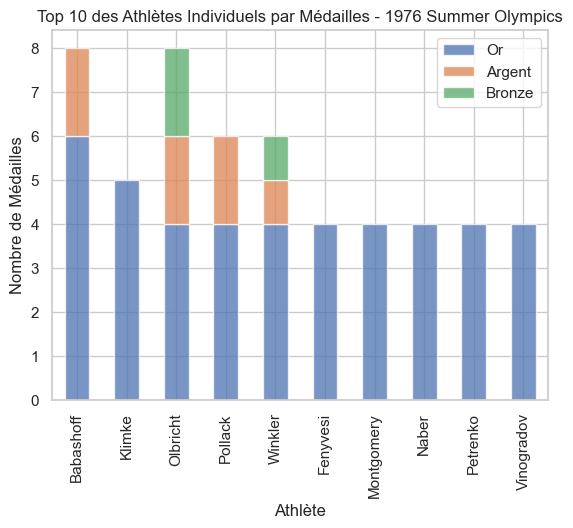

In [15]:
# Grouper les données par nom et prénom de l'athlète pour compter les médailles
top_10_individuals = data.groupby(['NOMATHLETE', 'PRENOMATHLETE', 'NOC'])[['NBOREQUIPE', 'NBARGENTEQUIPE', 'NBBRONZEEQUIPE']].sum().nlargest(10, columns=['NBOREQUIPE', 'NBARGENTEQUIPE', 'NBBRONZEEQUIPE']).reset_index()
top_10_individuals = top_10_individuals.rename(columns={'NOMATHLETE': 'Nom', 'PRENOMATHLETE': 'Prenom', 'NOC': 'NOC', 'NBOREQUIPE': 'Or', 'NBARGENTEQUIPE': 'Argent', 'NBBRONZEEQUIPE': 'Bronze'})

# Configurer le style de Seaborn
sns.set(style="whitegrid")

# Créer un bar plot avec Pandas pour visualiser le top 10 des athlètes individuels en fonction du nombre de médailles
plt.figure(figsize=(12, 8))
top_10_individuals.plot.bar(x='Nom', y=['Or', 'Argent', 'Bronze'], stacked=True, alpha=0.75)

# Ajouter un titre et des labels
plt.title('Top 10 des Athlètes Individuels par Médailles - 1976 Summer Olympics')
plt.xlabel('Athlète')
plt.ylabel('Nombre de Médailles')

# Afficher le graphique
plt.show()

##### Répartition par NOC

In [25]:
# Requête SQL pour récupérer les informations des médailles par NOC aux Jeux Olympiques d'été 1976
requete = """
SELECT N.CodeNOC, N.NomNOC,
    SUM(CASE WHEN PE.Medaille = 'Gold' THEN 1 ELSE 0 END) AS nbOr,
    SUM(CASE WHEN PE.Medaille = 'Silver' THEN 1 ELSE 0 END) AS nbArgent,
    SUM(CASE WHEN PE.Medaille = 'Bronze' THEN 1 ELSE 0 END) AS nbBronze,
    COUNT(PE.Medaille) AS nbMedaillesTotal
FROM 
    Participation_Equipe PE
    JOIN Equipe EQ ON PE.IdEquipe = EQ.IdEquipe
    JOIN Evenement E ON PE.IdEvenement = E.IdEvenement
    JOIN Hote H ON E.IdHote = H.IdHote
    JOIN NOC N ON EQ.NOC = N.CodeNOC
WHERE 
    h.LibelleHote LIKE :Libelle
    --H.AnneeHote = 1976
    --AND H.Saison = 'Summer'
GROUP BY N.CodeNOC, N.NomNOC
ORDER BY nbMedaillesTotal DESC, nbOr DESC, nbArgent DESC, nbBronze DESC
    FETCH FIRST 10 ROWS ONLY
    """
data = requete_vers_dataframe(conn,requete, {"Libelle": EDITION_JO})
data

,CODENOC,NOMNOC,NBOR,NBARGENT,NBBRONZE,NBMEDAILLESTOTAL
0,URS,Soviet Union,13,11,8,32
1,GDR,East Germany,13,7,6,26
2,USA,United States,7,6,3,16
3,FRG,West Germany,5,4,6,15
4,HUN,Hungary,1,1,6,8
5,GBR,Great Britain,2,3,2,7
6,POL,Poland,1,4,1,6
7,ROU,Romania,0,3,3,6
8,BUL,Bulgaria,2,1,1,4
9,FRA,France,1,1,1,3


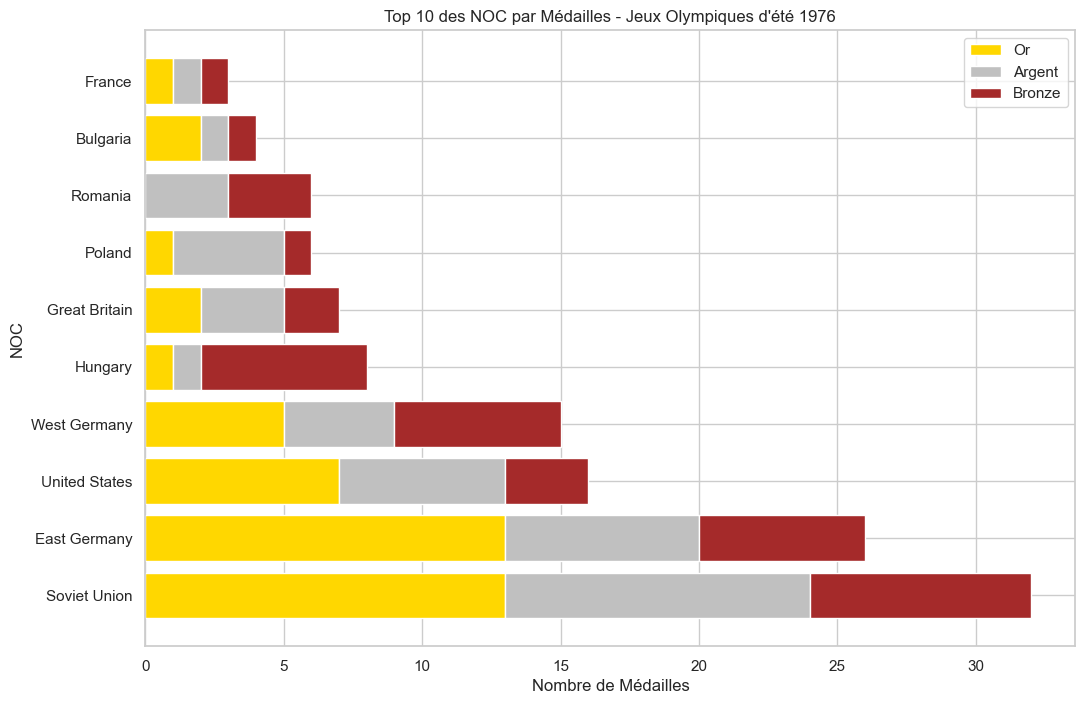

In [26]:
# Configurer le style de Seaborn
sns.set(style="whitegrid")

# Créer une figure matplotlib
plt.figure(figsize=(12, 8))

# Créer un bar plot avec Matplotlib pour visualiser les top 10 NOC par médailles
plt.barh(data['NOMNOC'], data['NBOR'], color='gold', label='Or')
plt.barh(data['NOMNOC'], data['NBARGENT'], left=data['NBOR'], color='silver', label='Argent')
plt.barh(data['NOMNOC'], data['NBBRONZE'], left=data['NBOR'] + data['NBARGENT'], color='brown', label='Bronze')

# Ajouter un titre et des labels
plt.title('Top 10 des NOC par Médailles - Jeux Olympiques d\'été 1976')
plt.xlabel('Nombre de Médailles')
plt.ylabel('NOC')

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()

## Partie modification des données

On décide d'ajouter à l'édition des JO étudiée une nouvelle épreuve : le tir à l'arc à poulies. C'est une épreuve de tir à l'arc (*archery*, code `ARC`), qui se fait soit en arc à poulies homme (individuel ou équipe, mais on ne traitera que le cas individuel), soit arc à poulies femmes (individuel ou équipe). Les noms à utiliser pour les événements seront :

- *Compound individual, Men*
- *Compound individual, Women*

Pour simuler les résultats, vous utiliserez les résultats de l'épreuve de [tir à l'arc classique des JO de 2020 en individuel homme](https://www.olympedia.org/results/18000492) en faisant comme s'il s'agissait d'arc à poulies : les athlètes existent déjà dans la base, vous devez maintenant faire en sorte d'ajouter à la base les différents résultats.

Avant de réaliser les modifications, affichez le tableau des médailles individuelles pour l'Italie

In [ ]:
# On donne ici l'exemple de comment ajouter un événement. On a stocké dans id_hote l'identifiant des JO sur lesquels on travaille
with Connexion(login=conn['login'], password=conn['password']) as connexion:  # Démarre une nouvelle connexion
    # On démarre une nouvelle transaction
    connexion.begin()
    # On ouvre un curseur, qui est une sorte de pointeur vers une table de résultats
    curseur = connexion.cursor()
    # On passe la requête paramétrée et les paramètres (s'il y en a) au curseur
    curseur.execute(f"SELECT MAX(IDEVENEMENT) FROM {SCHEMA}.EVENEMENT")
    # S'il n'y a pas d'erreur, on peut demander à récupérer les résultats : 
    # - curseur.fetchone() récupère la ligne sur laquelle pointe le curseur, renvoie le résultat sous forme de tuple, et avance à la ligne suivante (si elle existe)
    # - curseur.fetchall() boucle sur toutes les lignes restantes et renvoie une liste de tuples, ou une liste vide s'il n'y a plus de résultats
    # - curseur.fetchmany(nb) renvoie les résultats des nb lignes suivantes sous forme de liste de tuples
    idev = curseur.fetchone()[0]  # Renvoie un tuple, on veut le premier élément du tuple
    idev += 1
    curseur.execute(f"INSERT INTO {SCHEMA}.EVENEMENT VALUES(:idev, :nomev, :statutev, :codedisc, :idhote)", {'idev': idev, 'nomev': 'Compound Individual, Men', 'statutev': 'Olympic', 'codedisc': 'ARC', 'idhote': id_hote})
    connexion.rollback()  # On annule, ce qui est au dessus est pour l'exemple, vous devrez utiliser commit() pour valider la transaction.

In [15]:
# Afficher le tableau des médailles individuelles de l'Italie

requete = """
SELECT DISTINCT
    a.nomAthlete AS nom,
    a.prenomAthlete AS prenom,
    NBORINDIV AS NBOR,
    NBARGENTINDIV AS NBARGENT,
    NBBRONZEINDIV AS NBBRONZE
FROM
    TPLUMAS.ATHLETE a
INNER JOIN
    TPLUMAS.PARTICIPATION_INDIVIDUELLE PI ON a.idAthlete = pi.idAthlete
INNER JOIN
    TPLUMAS.medailles_individuelles MI ON a.IDATHLETE = mi.idAthlete
INNER JOIN
    TPLUMAS.NOC N ON pi.noc = n.codenoc
INNER JOIN
    TPLUMAS.EVENEMENT E ON pi.IDEVENT = e.IDEVENEMENT
INNER JOIN
    TPLUMAS.HOTE H ON e.IDHOTE = h.IDHOTE

WHERE
    h.LibelleHote LIKE '1976 Summer Olympics'
AND
    n.NOMNOC = 'Italy'
ORDER BY NBOR ,NBARGENT ,NBBRONZE 
"""
data = requete_vers_dataframe(conn,requete)
data

,NOM,PRENOM,NBOR,NBARGENT,NBBRONZE
0,Di Guida,Alfonso,0,0,0
1,Arcidiacono,Angelo,0,0,0
2,Zucca,Angelo,0,0,0
3,Roncelli,Antonella,0,0,0
4,Caltabiano,Antonino,0,0,0
...,...,...,...,...,...
122,Mennea,Pietro,1,0,1
123,Gamba,Ezio,1,1,0
124,D'Inzeo,Raimondo,1,1,0
125,Simeoni,Sara,1,2,0


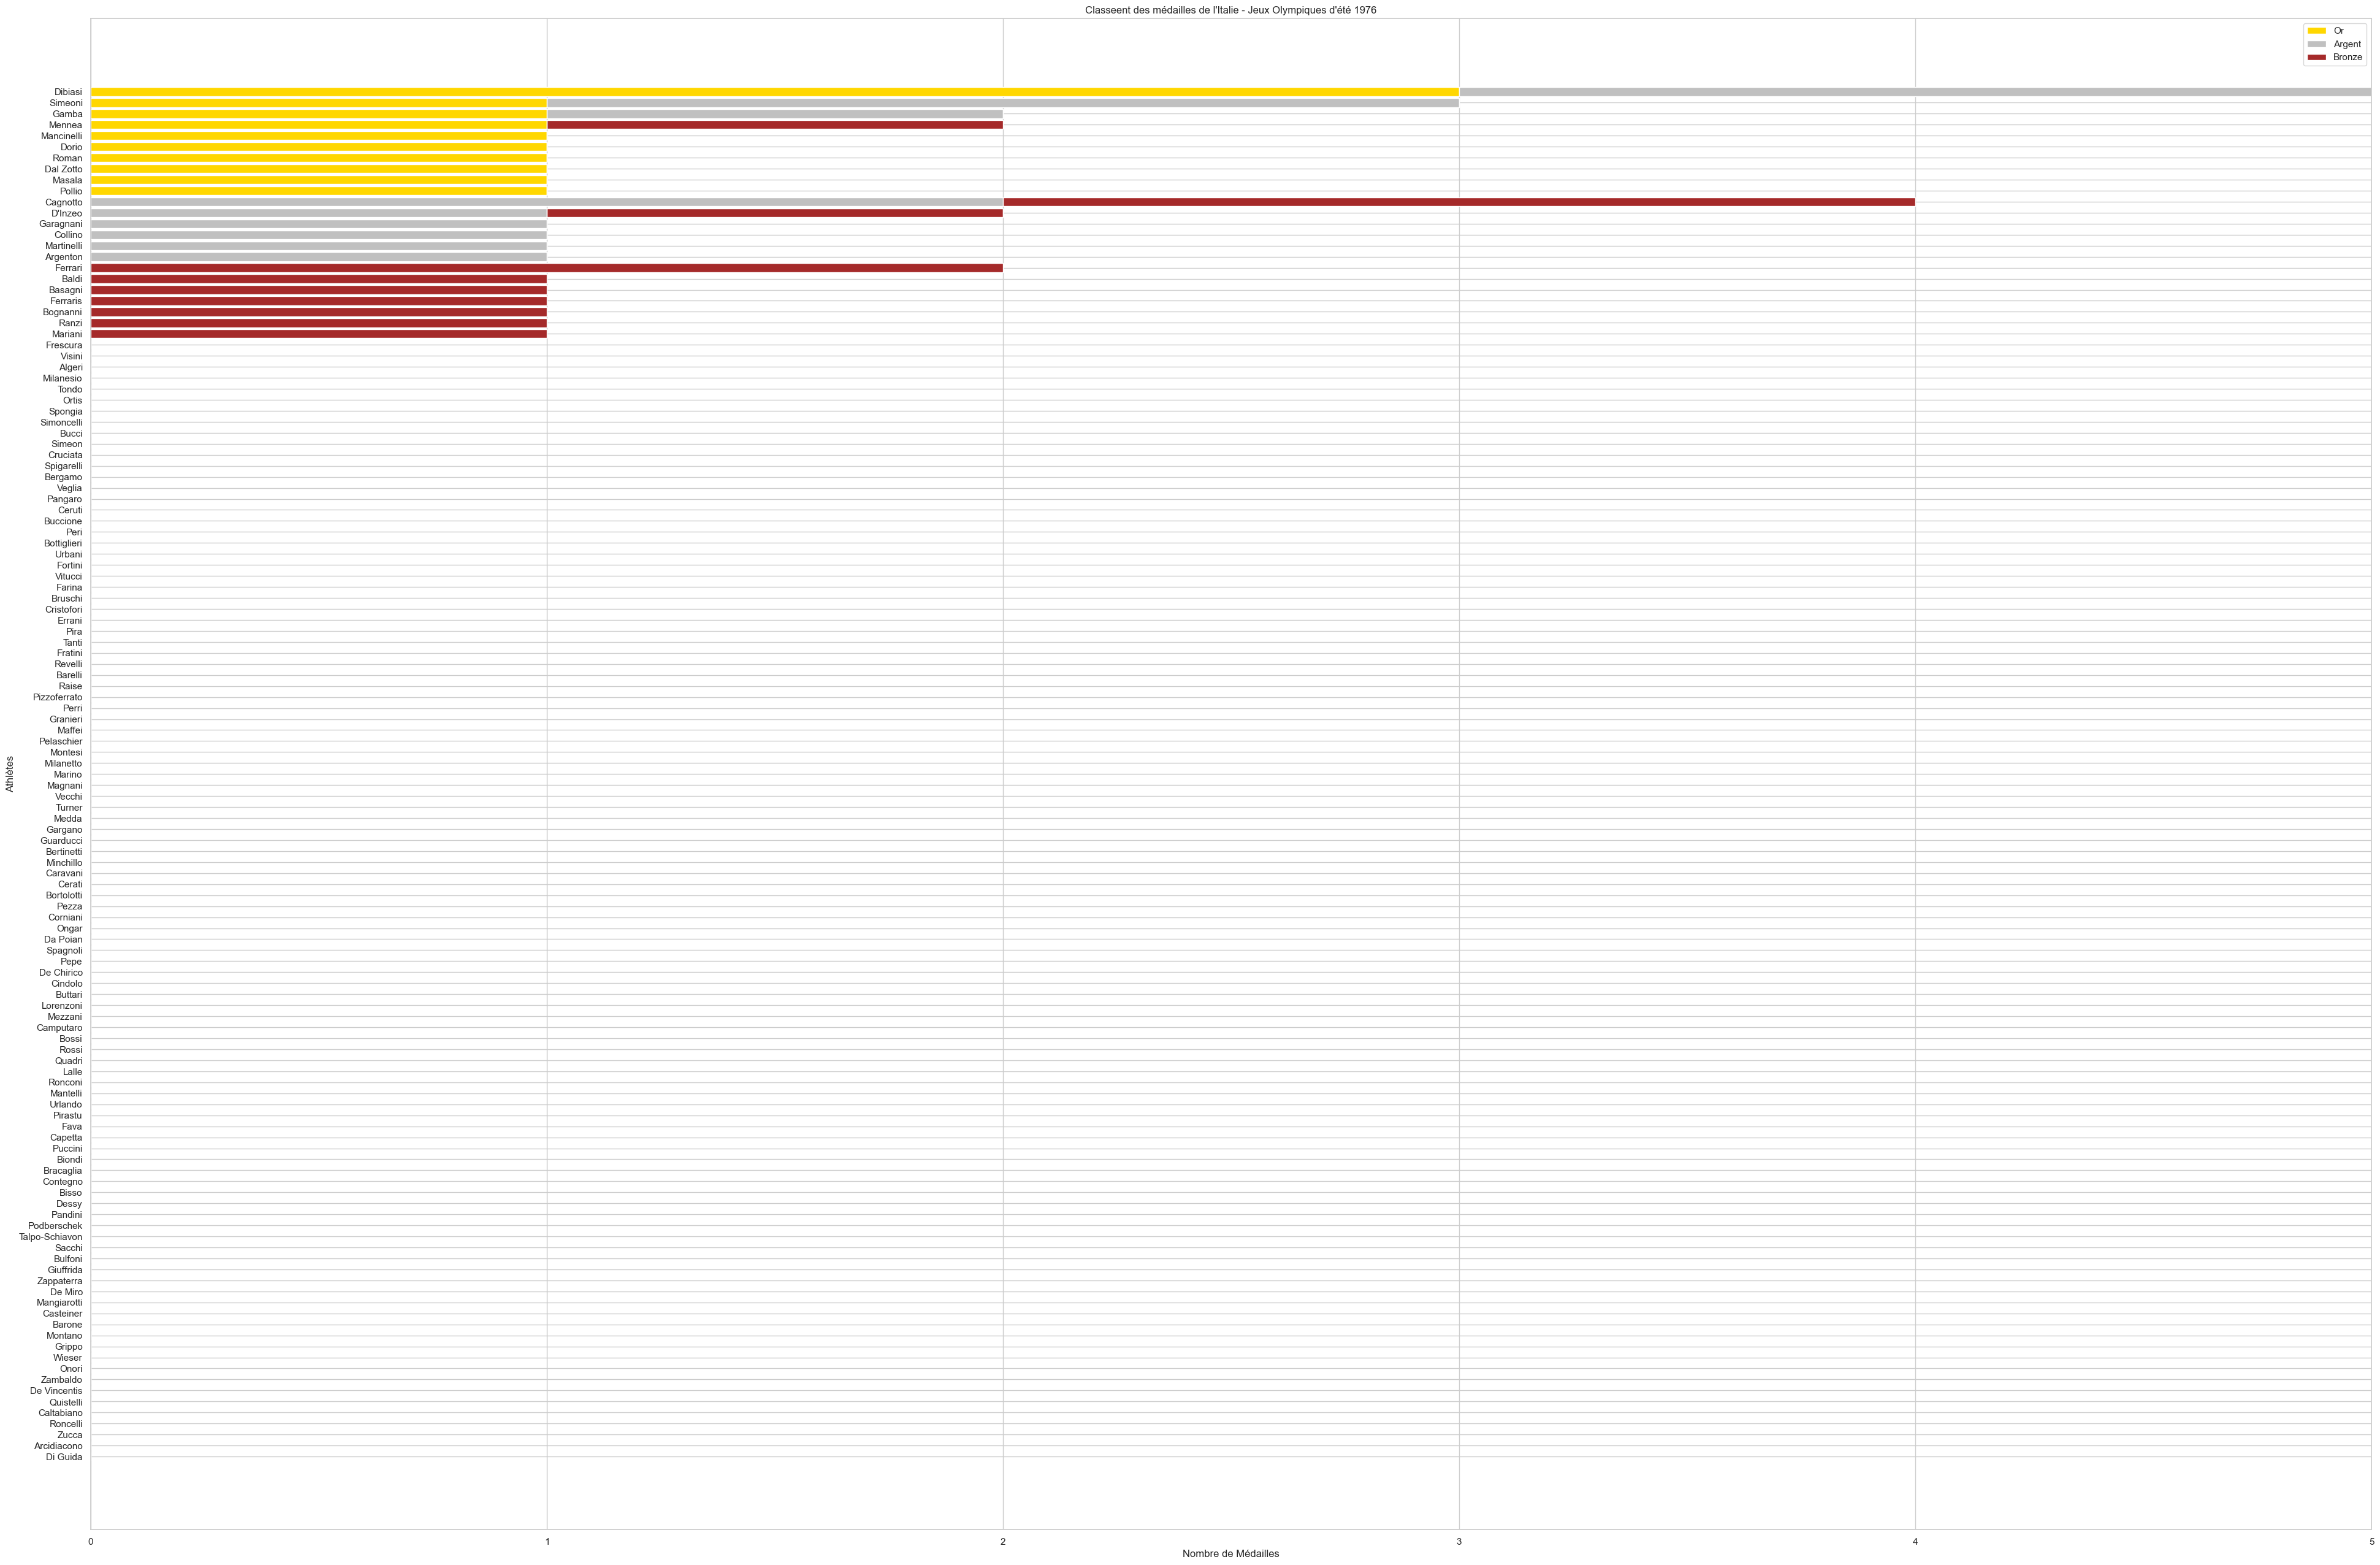

In [16]:
# Configurer le style de Seaborn
sns.axes_style("whitegrid")

# Créer une figure matplotlib
plt.figure(figsize=(48, 32))

# Créer un bar plot avec Matplotlib pour visualiser les top 10 NOC par médailles
plt.barh(data['NOM'], data['NBOR'], color='gold', label='Or')
plt.barh(data['NOM'], data['NBARGENT'], left=data['NBOR'], color='silver', label='Argent')
plt.barh(data['NOM'], data['NBBRONZE'], left=data['NBOR'] + data['NBARGENT'], color='brown', label='Bronze')

# Ajouter un titre et des labels
plt.title('Classeent des médailles de l\'Italie - Jeux Olympiques d\'été 1976')
plt.xlabel('Nombre de Médailles')
plt.ylabel('Athlètes')

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()

### Qualifications [Bonus]

Le round de qualifications en tir à l'arc à poulie est assez similaire au tir à l'arc classique, avec comme différence qu'il n'y a pas de "X", ils comptent comme des 10 pour départager. En utilisant le tableau des résultats de qualifications, faites en sorte que votre tableau de bord insère les données dans la base puis les affiche.

In [ ]:
# Faire ici l'insertion des données

In [ ]:
# Faire ici l'affichage du tableau de résultat des qualifications

### Première manche [Bonus]

Faire de même ici avec les résultats de la première manche. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [ ]:
# Faire ici l'insertion des données

In [ ]:
# Faire ici l'affichage du tableau de résultat de la première manche

### Deuxième manche [Bonus]

Faire de même ici avec les résultats de la deuxième manche. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [ ]:
# Faire ici l'insertion des données

In [ ]:
# Faire ici l'affichage du tableau de résultat de la deuxième manche

### Troisième manche [Bonus]

Faire de même ici avec les résultats de la troisième manche. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [ ]:
# Faire ici l'insertion des données

In [ ]:
# Faire ici l'affichage du tableau de résultat de la troisième manche

### Quarts de finale [Bonus]

Faire de même ici avec les résultats des quarts de finale. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [ ]:
# Faire ici l'insertion des données

In [ ]:
# Faire ici l'affichage du tableau de résultat des quarts de finale

### Demi-finales [Bonus]

Faire de même ici avec les résultats des demies-finales. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [ ]:
# Faire ici l'insertion des données

In [ ]:
# Faire ici l'affichage du tableau de résultat des demies-finales

### Finale [Bonus]

Faire de même ici avec les résultats de la finale. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [ ]:
# Faire ici l'insertion des données

In [ ]:
# Faire ici l'affichage du tableau de résultat de la finale

### Résultats des médailles

Pour terminer, saisir les résultats des médailles

In [ ]:
# Faire ici les insertions de données pour les résultats dans la table PARTICIPATION_INDIVIDUELLE

## Vérification

Afficher le tableau des médailles de l'Italie après les ajouts de la nouvelle épreuve.

In [ ]:
# Affichage du tableau (cf. début de la partie modification)

### Nettoyage

Supprimez maintenant tous les ajouts précédents (médailles, résultats détaillés, nouvelles épreuves) de votre base.

In [ ]:
# Nettoyage (avec des requêtes DELETE)